# Plate Reader Data Analysis

First, import the libraries

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path

Build a map that links the Compound ID to its plate number and Well ID.

It looks like some bad data got through! Notice the `nan`s that are showing up

A map is associates keys with values - for every particular key, there is an associated value.

Map is a general term for this concept - in `Python` it is called a dictionary.

There can only be 1 of each key - in our dictionary below, each key is the Compound ID
and each value is another dictionary that has the `plate_number` and `well_id`

In [12]:
p = Path('../data/Compound ID_plate layouts.xlsx')

def build_map():
    df = pd.read_excel(p, header=1, sep=',')

    wanted_data = df.iloc[:, [1,2,3]]

    # Verify data in file here
    # remove rows if NaN

    compound_ids = wanted_data['CBCSMR_NSC_ID'].tolist()
    plate_numbers = wanted_data['Plate # '].tolist()
    well_ids = df['Well ID'].tolist()

    dictionary = {}
    for compound, plate_number, well_id in zip(compound_ids, plate_numbers, well_ids):
        if compound not in dictionary:
            dictionary[compound] = dict(plate_number=plate_number, well_id=well_id)
        else:
            print('I found a repeat compound!: {}'.format(compound))
    
    return dictionary


In [13]:
def generate_plate_dicts(plates_data):
    plate_one = {}
    plate_two = {}

    for key, value in plates_data.items():
        well_id = value['well_id']
        if float(value['plate_number']) == 1.0:
            plate_one[well_id] = key
        elif float(value['plate_number']) == 2.0:
            plate_two[well_id] = key
        else:
            print("improperly formed data: {},{}".format(key,value))

    return plate_one, plate_two

In [14]:
plates_data = build_map()

print('Count of plate cells: ', len(plates_data))

plate_one, plate_two = generate_plate_dicts(plates_data)

I found a repeat compound!: 2501528.0
Count of plate cells:  206
improperly formed data: nan,{'plate_number': nan, 'well_id': nan}
improperly formed data: 6.375,{'plate_number': nan, 'well_id': nan}
improperly formed data: 25.5,{'plate_number': nan, 'well_id': nan}


# A new approach
Look at the Location List sheet and assign the compounds based on that

### Set the `path` to change which data the program reads

In [21]:
plate_layout_path = '../data/Compound ID_plate layouts.xlsx'
data_path = '../data/135948_1340.csv'

# Helper Functions

In [46]:
# pass in the plate number
def compound_id_by_location(number):
    lookup = {1:'Plate 1',2:'Plate 2',3:'Plate 3',4:'Plate 4',5:'Plate 5',6:'Plate 6'}
    xls = pd.ExcelFile(plate_layout_path)
    df = xls.parse('Location List')
    plate_number = lookup[number]
    return df[df['IC50 Plate'].isin([plate_number])]

# Open the data file as `readable` and save it as the variable `f`
def open_data_file():
    f = open(data_path, 'r')
    return f

# Create the `dataframe` with the `csv` file
def convert_to_plate_df(file):
    header_names = [x for x in range(25)]
    df = pd.read_csv(file, sep=',', header=7, names=header_names)
    return df

def return_well(df):
    columns = df[:16]
    well = columns[np.array(range(24))].astype(np.int32)
    return well

def generate_max_and_min(well):
    # slice part of the well dataframe
    max_values = well[[0, 1]]
    min_values = well[[22, 23]]
    # extract the values
    # can do some filtering for outliers here
    max_values = [item for sublist in max_values.values for item in sublist]
    min_values = [item for sublist in min_values.values for item in sublist]
    # convert to Series type
    max_values = pd.Series(max_values)
    min_values = pd.Series(min_values)
    return max_values, min_values

def calculate_mean(series):
    return series.mean()

def calculate_stddev(series):
    return series.std()

def calculate_z_factor(std_max, std_min, mean_max, mean_min):
    return 1 - 3 * (std_max + std_min) / (mean_max - mean_min)

def calculate_sb_ratio(mean_max, mean_min):
    return mean_max / mean_min

def min_max_scaling(well, mean_max, mean_min):
    return well.apply(lambda x: ((x - mean_min) / (mean_max - mean_min)) * 100)

def standardize_to_one_hundred(well):
    return well.apply(lambda x: 100 - x)



Lets take a look at a well

In [42]:
data_file = open_data_file()
plate_df = convert_to_plate_df(data_file)
well = return_well(plate_df)

pprint(well)

       0      1      2      3      4      5      6      7      8      9   \
0   61593  65101  60700  68186  70282  76049  75693  80395  74204  73110   
1   54284  61669  52303  59404  60480  68037  68778  69382  73469  66552   
2   59851  61959  41725  53146  59101  64685  66413  70348  68668  64440   
3   59948  61198  54592  58688  61381  63866  66565  67013  70763  63874   
4   58494  59157  57720  61819  61098  65165  67678  67461  68930  63602   
5   60874  58403  56259  62528  63258  66536  64586  66665  65429  63383   
6   60349  66189  54997  63900  62551  66980  63184  68923  68833  64742   
7   60643  59799  56176  60180  58952  57312  61046  63442  63059  62324   
8   62320  62645  56435  61895  64424  66761  64929  67560  68536  60081   
9   59560  55225  61353  61683  63228  63823  64204  63313  61061  58543   
10  53476  57388  38360  45585  43191  60008  54848  62659  66322  57776   
11  50346  50302  48800  53052  57617  58145  58030  60623  62254  61665   
12  46966  4

Get the max and min values. `max_values` will be the first 2 columns and `min_values` will be the last 2 columns

In [43]:
max_values, min_values = generate_max_and_min(well)

Determine the mean and standard deviation for the `max_values` and the `min_values`, along with the z factor

Calculate the mean $\bar{X}$ using $\frac{1}{n} \displaystyle\sum_{i=1}^{n} x_{i}$

In [44]:
mean_max = calculate_mean(max_values)
std_max = calculate_stddev(max_values)

mean_min = calculate_mean(min_values)
std_min = calculate_stddev(min_values)

sb_ratio = calculate_sb_ratio(mean_max, mean_min)

z_factor = calculate_z_factor(std_max, std_min, mean_max, mean_min)

Standardize the values using min max scaling

Let $\bar{m}$ be the average of the max values and $\bar{n}$ be the average of the min values

$f(x) = \frac{x - \bar{n}}{\bar{m} - \bar{n}} \times 100$

In [47]:
min_max_scaled_data = min_max_scaling(well, mean_max, mean_min)

Subtract the standardized data from 100

$f(x) = 100 - x$

In [49]:
standardized_data = standardize_to_one_hundred(min_max_scaled_data)

pprint(standardized_data)

           0          1          2          3          4          5   \
0  -10.469792 -16.895094  -8.834161 -22.545623 -26.384686 -36.947604   
1    2.917475 -10.608994   6.545902  -6.460389  -8.431205 -22.272712   
2   -7.279120 -11.140163  25.920715   5.001852  -5.905410 -16.133142   
3   -7.456787  -9.746304   2.353338  -5.148953 -10.081490 -14.633050   
4   -4.793620  -6.007980  -3.375951 -10.883737  -9.563143 -17.012317   
5   -9.152861  -4.626943  -0.699963 -12.182351 -13.519429 -19.523460   
6   -8.191264 -18.887890   1.611534 -14.695325 -12.224478 -20.336696   
7   -8.729759  -7.183876  -0.547939  -7.881721  -5.632499  -2.628652   
8  -11.801375 -12.396650  -1.022327 -11.022939 -15.655091 -19.935573   
9   -6.746121   1.193926 -10.030204 -10.634637 -13.464481 -14.554291   
10   4.397419  -2.767855  32.084096  18.850685  23.235569  -7.566684   
11  10.130371  10.210962  12.962046   5.174023  -3.187295  -4.154387   
12  16.321226  15.577591  32.618928  11.146917   8.269451   3.28

Create a mapping between the numbers and letters. This pattern can be used when you want to associate 2 values.  If you have any of the keys (the integers on the right) then you can look up in this dictionary to get the values.  This method becomes less useful as the size of the map increases, unless you can programatically generate it

In [50]:
letter_number_map = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P'
}


Lets programatically generate our map this time! The key is the array index while the value is the concentration. Each concentration is halfed each time the index grows by 1

In [57]:
# builds a dict that has the logarithmic decay of concentrations
def generate_conc_index_map(start, size):
    m = dict()
    for i in range(size):
        m[i] = start
        start = start/2
    return m

# less than 3 and greater than 22 means no compound id
def build_plate_compound_data(dataframe):
    plate_and_compound_data = {}
    # row index can be used with the lookup dict above
    for row_index, row_value in df.iterrows():

        # first character is a letter followed by 2 numbers
        well_index = row_value['Top Concentration Well']

        # len is 7
        local_compound_id = row_value['Compound_ID']

        # letter of the well index
        row_letter = well_index[0]

        row_number = int(well_index[1:])

        # iterate out
        for i in range(row_number, row_number+10):
            plate_index = '{0}{1}'.format(row_letter,i)
            plate_and_compound_data[plate_index] = {'compound_id':local_compound_id}
            
    return plate_and_compound_data

# this function accepts the fully normalized plate data
def add_values_to_plate_compound_data(plate_df, data):
    # remove first 2 and last 2 columns
    df = plate_df[[i for i in range(2,22)]]
    
    for row, value in df.iterrows():
        # len(l) is 20
        l = list(value)
        lookup_key_letter = letter_number_map[row]
        for i, v in enumerate(l):
            lookup_key = '{0}{1}'.format(lookup_key_letter, i+3)
            data[lookup_key]['value'] = v
            # add in the concentration data
            conc_index = i % 10
            data[lookup_key]['concentration'] = index_conc_map[conc_index]
            
    return data


In [58]:
index_conc_map = generate_conc_index_map(40.0, 10)

df = compound_id_by_location(1)

p = build_plate_compound_data(df)

to_df = add_values_to_plate_compound_data(standardized_data, p)
pprint(to_df)

{'A10': {'compound_id': 2582346,
         'concentration': 0.3125,
         'value': -31.564490270409209},
 'A11': {'compound_id': 2582346,
         'concentration': 0.15625,
         'value': -39.088760586872041},
 'A12': {'compound_id': 2582346,
         'concentration': 0.078125,
         'value': -23.021842569342326},
 'A13': {'compound_id': 2534511,
         'concentration': 40.0,
         'value': -29.513082589192464},
 'A14': {'compound_id': 2534511,
         'concentration': 20.0,
         'value': -35.474986162728584},
 'A15': {'compound_id': 2534511,
         'concentration': 10.0,
         'value': -42.980940339180563},
 'A16': {'compound_id': 2534511,
         'concentration': 5.0,
         'value': -52.523649284840587},
 'A17': {'compound_id': 2534511,
         'concentration': 2.5,
         'value': -57.175948847599983},
 'A18': {'compound_id': 2534511,
         'concentration': 1.25,
         'value': -46.754065181418525},
 'A19': {'compound_id': 2534511,
         'conce

# Going into a dataframe
We now have the data set up in a Python dictionary. It needs to go into a dataframe now so that it can easily be graphed. Now that the data is in this format, I realize that I probably could have avoided the Python dictionary and just built using dataframes. Sometimes you never learn how to actually solve a problem until after you solve it the first time.

In [60]:
def graph_one_preprocess(d):
    output = dict()
    for index, (key, value) in enumerate(d.items()):
        output[index] = dict(position=key, **value)
    return output


In [61]:
preprocessed = graph_one_preprocess(to_df)

full_df = pd.DataFrame(preprocessed).transpose()

print(full_df)

    compound_id concentration position     value
0       2501528          1.25       L8  -8.69313
1       2573173      0.078125      K22   -6.8029
2       2562579             5       K6  -7.56668
3       2501528            40       L3    12.962
4       2576618             5      O16  -1.78061
5       2516967            40      J13  -9.45325
6       2566716            10       G5  -12.2245
7       2565807      0.078125      B22  -22.1738
8       2562579          1.25       K8  -12.4223
9       2565807          1.25      B18  -39.3104
10      2582346       0.15625      A11  -39.0888
11      2570869      0.078125      E22  -23.0914
12      2582342       0.15625      D11  -22.3789
13      2573344            10      N15  -5.39622
14      2582409            20      F14  -9.84704
15      2578109      0.078125      D22  -25.3645
16      2570451            10      L15   -11.131
17      2576618            40      O13   6.63382
18      2570287            40       O3    9.7787
19      2568833     

In [62]:
# uncomment the line below and run this cell if you would like to save the data to file!

# full_df.to_csv('data.csv', sep=',')

Begin to implement the graph! Still a work in progress

In [115]:
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk', rc={'lines.linewidth': 2})



def build_graph(full_df):
    # need to round the values so it doesn't break the graph
    values = list(full_df['value'])
    rounded_values = np.around(values, decimals=3)
    # add the rounded values to the dataframe
    full_df['rounded_values'] = rounded_values
    
    # build graph
    ax = sns.swarmplot(x='concentration',
                       y='rounded_values',
                       hue='compound_id',
                       #palette=sns.color_palette("RdBu", n_colors=len(full_df['compound_id'])),
                       data=full_df)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)


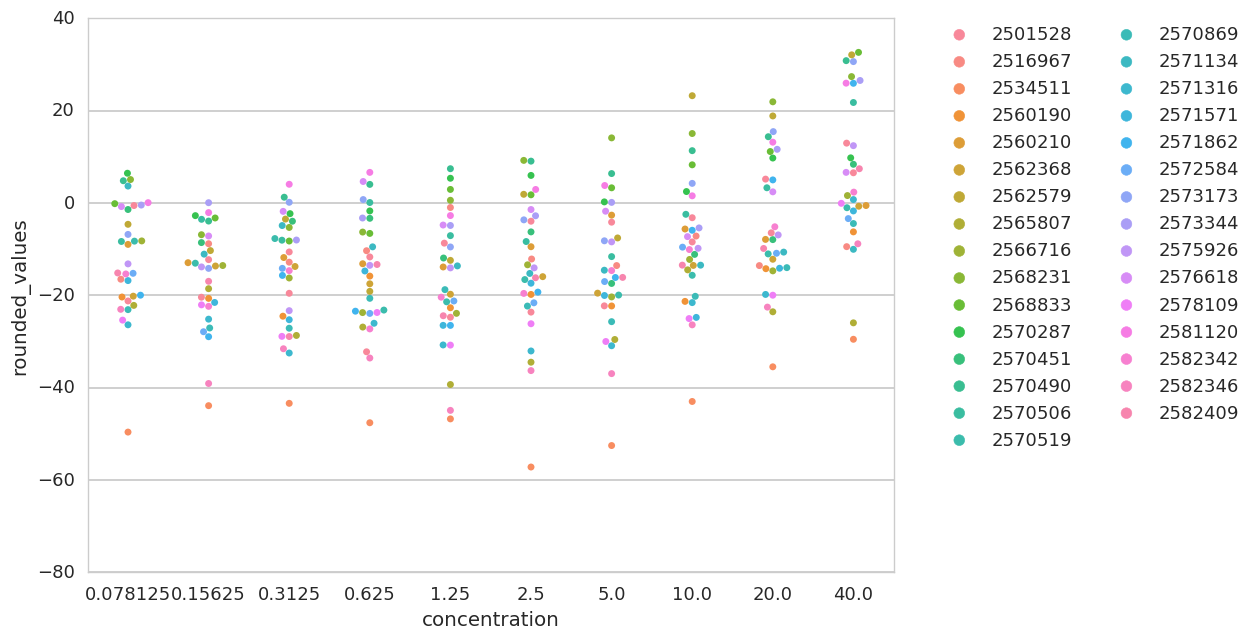

In [116]:
build_graph(full_df)